In [ ]:
!pip install sastrawi

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import re
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

import mimetypes
from datetime import timedelta
from wordcloud import WordCloud
from textwrap import wrap

import nltk
nltk.download('punkt')

from nltk.util import ngrams


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
stopwords = stop_factory = StopWordRemoverFactory().get_stop_words()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# deklarasi folder dataset
DATA_DIR = '/content/gdrive/MyDrive/VIX/UMNC/data'

# Data Preprocessing

## Stemming dengan Sastrawi

In [ ]:
# imported from iFest 2021 Data Cleaning Module by Yaudahlah Teams,
# Refactored by Kaenova Mahendra Auditama (Yaudahlah Teams)

class DataCleaning:
  def __init__(self, stopword:list = [], slang_word:dict = {}) -> None:
    factory     = StemmerFactory()
    self.stemmer     = factory.create_stemmer()
    self.stopword = stopword
    self.slang_word = slang_word

  def AddKamusAlay(self, new_dict:dict = {}):
    if (type(new_dict) != dict): raise TypeError("Not a valid type")
    self.slang_word = self.slang_word | new_dict

  def AddStopWord(self, stopword:list = []):
    if (type(stopword) != list): raise TypeError("Not a valid type")
    self.custom_word = self.custom_word + stopword

  def CleanDataFrame(self, df:pd.DataFrame, text_cols:str, label_cols:str,
                     word_min:int=0, label_mapping:dict=None, dropna:bool=False, verbose=False):
    """
    Using multiprocessing (*if available) to process data from pandas Dataframe.
    Will be outputing a new dataframe with a processed data.
    """
    print("Processing...")
    final_list_clean = []
    final_list_dirty = []
    final_label = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
      sentence = row[text_cols]
      label = row[label_cols]

      # Process label
      if label_mapping is not None:
        if label not in label_mapping:
          print(f"Label {label} is not matched any label_mapping you've defined. This label will be ignored")
          continue
        clean_label = label_mapping[label]
      else:
        clean_label = label

      # Process Text
      clean_sentence = self.__cleanText__(sentence, self.slang_word,
                                          self.stopword, self.stemmer, verbose)
      if (clean_sentence is None):
        print(f"Sentence '{sentence}' is empty after processing. This sentence will be ignored")
        continue
      if (len(clean_sentence.split()) < word_min):
        continue

      final_list_clean.append(clean_sentence)
      final_list_dirty.append(sentence)
      final_label.append(clean_label)

    # Creating pandas dataframe
    data = {
      'raw': final_list_dirty,
      'processed': final_list_clean,
      'label': final_label
    }
    final_df = pd.DataFrame(data)
    if dropna:
      print("NaN Dropped")
      final_df = final_df.dropna(how='any')
    final_df['processed'] = final_df['processed'].astype(str)
    final_df['raw'] = final_df['raw'].astype(str)

    return final_df

  def CleanOneText(self, text, verbose=False):
    return self.__cleanText__(text, self.slang_word, self.stopword, self.stemmer, verbose)

  def __cleanText__(self, text:str, slangword:dict, stopword:list, stemmer, verbose=False) -> str:
    '''
    Processing a text, deleting some web associated word, removing word from stopword list
    and change defined slang word.
    '''
    # HTML and text annotation removal
    text = re.sub(r'http\S+', '', text)
    text = re.sub('(@\w+|#\w+)','',text)
    text = re.sub('<.*?>', '', text)
    temp_text = list(text)
    for i in range(len(temp_text)):
      if temp_text[i] in string.punctuation:
        temp_text[i] = " "
    text = ''.join(temp_text)
    text = re.sub('[^a-zA-Z]',' ',text)
    text = re.sub("\n"," ",text)
    text = text.lower()
    text = re.sub("(username|user|url|rt|xf|fx|xe|xa)\s|\s(user|url|rt|xf|fx|xe|xa)","",text)
    text = re.sub(r'(\w)(\1{2,})', r"\1", text)
    text = re.sub(r"\b[a-zA-Z]\b","",text)
    text = re.sub('(s{2,})',' ',text)
    if verbose:
      print(f"After Special Character : {text}")
    text = text.lower()
    if verbose:
      print(f"After Lower : {text}")
    text=' '.join(text.split())
    text_split = text.split(' ')
    final_text_split = []
    for i in range(len(text_split)):
      if type(text_split[i]) != str:
        continue
      if str(text_split[i]) in stopword:
        continue
      if str(text_split[i]) in slangword:
        text_split[i] = str(slangword[text_split[i]])
      final_text_split.append(text_split[i])
    text = " ".join(final_text_split)
    if verbose:
      print(f"After Stopword and Slangword : {text}")
    stemmed_text = stemmer.stem(text)
    if verbose:
      print(f"After Stemming : {stemmed_text}")

    # just to make sure
    if len(stemmed_text) == 0:
      return None

    return stemmed_text

## Preparing Slang Word

In [ ]:
kamus_alay1 = pd.read_csv('https://raw.githubusercontent.com/fendiirfan/Kamus-Alay/main/Kamus-Alay.csv')
dict_kamus_alay1 = {}
for _,row in kamus_alay1.iterrows():
    if row["kataBaik"] is np.NaN:
        continue
    dict_kamus_alay1[row["kataAlay"]] = row["kataBaik"]

In [ ]:
kamus_alay2 = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')
kamus_alay2 = kamus_alay2.filter(['slang', 'formal'], axis=1)
kamus_alay2 = kamus_alay2.drop_duplicates(subset=['slang'], keep='first')
dict_kamus_alay2 = {}
for _,row in kamus_alay2.iterrows():
    if row["formal"] is np.NaN:
        continue
    dict_kamus_alay2[row["slang"]] = row["formal"]

## Instantiate Cleaner

In [ ]:
cleaner = DataCleaning([], {**dict_kamus_alay1, **dict_kamus_alay2})

## Script for cleaning text Twitter

In [ ]:
RAW_DIR = f"{DATA_DIR}/Raw"
PROCESSED_DIR = f"{DATA_DIR}/Processed"

In [ ]:
pd.read_csv('/content/gdrive/MyDrive/VIX/UMNC/data/Raw/merged.csv').columns

Index(['like', 'reply', 'retweet', 'time', 'username', 'text', 'status',
       'tweet_link'],
      dtype='object')

In [ ]:
def clean_files_dir(cleaner: DataCleaning, src_dir:str, dst_dir:str,
                    text_column: str):
    # Removing files in destination if exists
    files = os.listdir(dst_dir)
    for file in files:
        if os.path.isdir(dst_dir + f"/{file}"):
          continue
        os.remove(dst_dir + f"/{file}")

    # Cleaning files
    files = os.listdir(src_dir)
    for file in files:
        if os.path.isdir(file):
          continue

        print(f"Processing file {file}")
        df = pd.read_csv(src_dir+f"/{file}")
        df['clean'] = df['text'].apply(lambda x: cleaner.CleanOneText(str(x)))

        df = df.drop_duplicates()
        df = df.dropna()
        df.to_csv(dst_dir+f"/{file}", index=False)

clean_files_dir(cleaner, RAW_DIR, PROCESSED_DIR, "text")

Processing file merged.csv


Improving Cleaning Data   
This needs to be done because there's some duplicates on "clean" column. This gives us insight that there's some tweet that have same context. Like a newsline and spam. Hence, we need to remove that and keep it only the first one. This can be seen on the "clean data moderna v1"

In [ ]:
# We are going to clean all the duplicates on "clean" column on every dataset
based_column_clean = "clean"

def clean_duplicates(input_dir:str, column:str=None) -> None:
  new_input_dir = input_dir+"/improved/"
  if not os.path.exists(new_input_dir):
    os.mkdir(new_input_dir)
  list_file = os.listdir(input_dir)
  for i in list_file:
    cur_file = input_dir+f"/{i}"
    if mimetypes.guess_type(cur_file)[0] != "text/csv":
      continue
    df = pd.read_csv(cur_file)
    df = df.drop_duplicates(subset=column)
    output_dir = new_input_dir+f"{i}"
    df.to_csv(output_dir, index=False)
    print(f"{i} has been cleaned and outputted to {output_dir}")

clean_duplicates(PROCESSED_DIR, based_column_clean)

merged.csv has been cleaned and outputted to /content/gdrive/MyDrive/VIX/UMNC/data/Processed/improved/merged.csv


Let's clean up tweet with the links  
Because link tend to direct to a news

In [ ]:
# We are going to clean all the duplicates on "clean" column on every dataset
# reference: https://stackoverflow.com/questions/39948757/how-to-delete-rows-in-python-pandas-dataframe-using-regular-expressions

input_path = f"{PROCESSED_DIR}/improved"
output_path = f"{PROCESSED_DIR}/improved v2"

def remove_row_with_links(input_dir:str, output_path) -> None:
  if not os.path.exists(output_path):
    os.mkdir(output_path)
  list_file = os.listdir(input_dir)
  for i in list_file:
    cur_file = input_dir+f"/{i}"
    if mimetypes.guess_type(cur_file)[0] != "text/csv":
      continue
    df = pd.read_csv(cur_file)
    patternDel = "https://t.co" # Beccause so many news with this links
    filter = df['text'].str.contains(patternDel)
    df = df[~filter].reset_index(drop=True)
    output_dir = output_path+f"/{i}"
    df.to_csv(output_dir, index=False)
    print(f"{i} has been cleaned and outputted to {output_dir}")

remove_row_with_links(input_path, output_path)

merged.csv has been cleaned and outputted to /content/gdrive/MyDrive/VIX/UMNC/data/Processed/improved v2/merged.csv


## Tahapan Preprocessing

In [ ]:
text = "AKU KE PRJ SENDIRI bismillah aja duluu ngilangin stress"

In [ ]:
cleaner.CleanOneText(text, True)

After Special Character : aku ke prj sendiri bismillah aja duluu ngilangin stre 
After Lower : aku ke prj sendiri bismillah aja duluu ngilangin stre 
After Stopword and Slangword : saya ke prj sendiri bismillah saja dulu menghilangkan stre
After Stemming : saya ke prj sendiri bismillah saja dulu hilang stre


'saya ke prj sendiri bismillah saja dulu hilang stre'

# Exploratory Data Analysis

In [ ]:
data = []
title = []
input_path = f"{DATA_DIR}/Processed/improved v2"

list_data = os.listdir(input_path)
for i in list_data:
  cur_file = input_path + f"/{i}"
  if mimetypes.guess_type(cur_file)[0] != "text/csv":
      continue
  title.append(i)
  data.append(pd.read_csv(cur_file))

In [ ]:
# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330,
                 max_words=100, background_color='white', #colormap="Pastel1",
                 scale=2, stopwords=stopwords,
                 collocations=False).\
                 generate(data.to_string())  #collocation - bigram
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.title(title)
  plt.axis("off")
  plt.show()


Options on wordcloud: [here](https://towardsdatascience.com/how-to-create-beautiful-word-clouds-in-python-cfcf85141214)

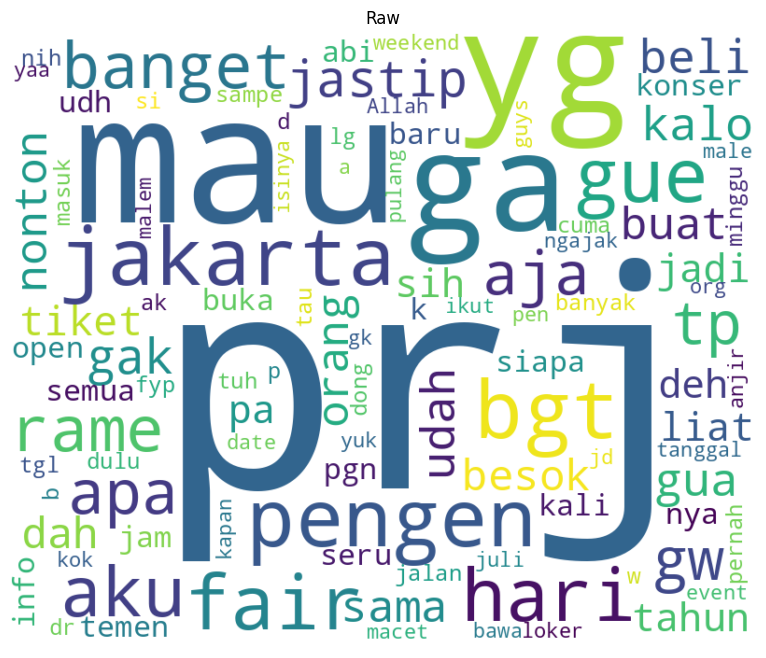

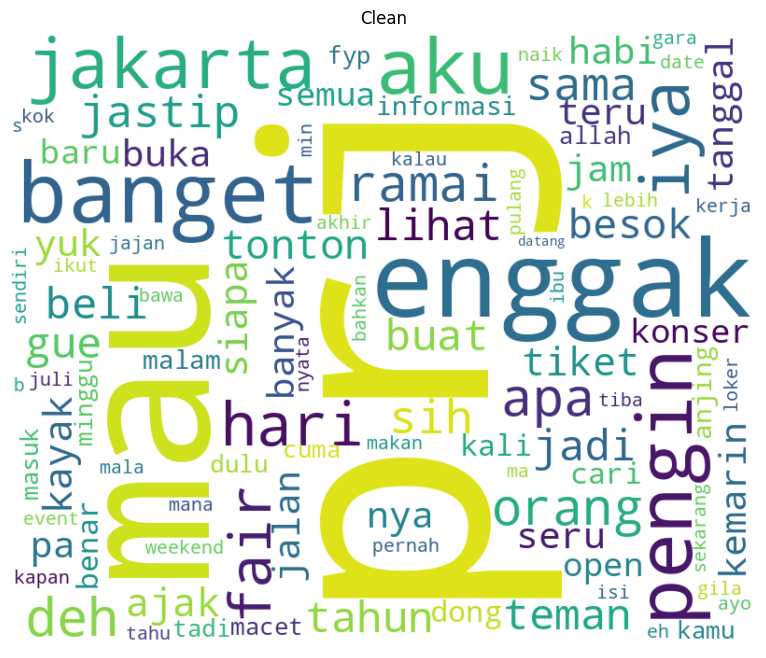

-------------------------------------


In [ ]:
for i,df in enumerate(data):
  generate_wordcloud(df['raw'], "Raw")#title[i])
  print('\n\n')
  generate_wordcloud(df['clean'], "Clean")#title[i])
  print('-------------------------------------')

# Modeling

## Install Prerequisite Library

In [ ]:
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 8.2 MB/s eta 0:00:00


In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.4 MB/s eta 0:00:00


RESTART RUNTIME

In [ ]:
seq_length = 256
pad_approach = "max_length"
bert_huggingface = "indolem/indobertweet-base-uncased" #uncased because we're using lower casing for all text data
num_epoch = 3

## Predict Data

The Datasets must consist of "text" column name and "labels" column name
  
And for the "label" we need to process 0 as negative sentiment and 1 as positive sentiment

In [ ]:
# Get All csv data paths
from transformers import AutoTokenizer, BertForSequenceClassification, Trainer
import tensorflow as tf
import pandas as pd
from datasets import load_dataset

data = {
    "prj" : f"{DATA_DIR}/Processed/improved v2/merged.csv"
    # "prj" : "/content/gdrive/MyDrive/VIX/UMNC/data_NDETC/Processed/improved v2/merged.csv"
}

csv_out_data_path = f"{DATA_DIR}/Predicted"

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(bert_huggingface)
model = BertForSequenceClassification.from_pretrained(bert_huggingface, num_labels=2)
model = Trainer(model)

# tokenize text
def tokenize_text_data(dataset_row):
    return tokenizer(str(dataset_row["clean"]), max_length=seq_length,
                     truncation=True, padding="max_length")
tokenized = load_dataset('csv', data_files=data)
tokenized = tokenized.map(tokenize_text_data)

# Predict all data
for i in data:
    data_path = data[i]
    df = pd.read_csv(data_path)

    model_prediction = model.predict(tokenized[i])
    logits = model_prediction.predictions
    softmax = tf.compat.v1.math.softmax(logits)
    out_ids = tf.math.argmax(softmax, axis=1).numpy()

    df["prediction"] = out_ids
    df.to_csv(f"{csv_out_data_path}/{i}.csv")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df['prediction'].value_counts()

1    6055
0    2071
Name: prediction, dtype: int64

# Preparing the Data for Dashboarding

## Data + Formatted Date

In [ ]:
df = pd.read_csv(f'{DATA_DIR}/Predicted/prj.csv')
df['time'] = df['time'].apply(lambda x: (pd.to_datetime(x) + timedelta(hours=7))\
                                      .strftime('%Y-%m-%d %H:%M:%S'))
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.to_csv(f"{DATA_DIR}/labeled.csv")

## Data Hashtag

Isolate all hashtag into list

In [ ]:
df_ht = pd.read_csv(f'{DATA_DIR}/Predicted/prj.csv')
df_ht.head()

,Unnamed: 0,like,reply,retweet,time,username,text,status,tweet_link,clean,prediction
0,0,0,0,0,2023-07-08T09:16:02.000Z,@seyn1101,PRJ masih penuh aja yaaa,1677607464538345473,https://twitter.com/@seyn1101/status/167760746...,prj masih penuh saja iya,1
1,1,0,0,0,2023-07-08T09:15:46.000Z,@chupaahupss,"yang paling aneh itu, tiba² gua di PRJ",1677607398125752321,https://twitter.com/@chupaahupss/status/167760...,yang paling aneh itu tiba aku di prj,1
2,2,0,0,0,2023-07-08T09:05:22.000Z,@klmneedfood,AKU KE PRJ SENDIRI bismillah aja duluu ngilan...,1677604780078923777,https://twitter.com/@klmneedfood/status/167760...,saya ke prj sendiri bismillah saja dulu hilang...,1
3,3,0,0,0,2023-07-08T09:03:51.000Z,@CitizensMills,Rame bgt ya prj,1677604399965958145,https://twitter.com/@CitizensMills/status/1677...,ramai banget iya prj,1
4,4,0,0,0,2023-07-08T09:00:01.000Z,@cacaicaaci,orang orang di prj ngapain sih,1677603433380216833,https://twitter.com/@cacaicaaci/status/1677603...,orang orang di prj kapai sih,1


### Exploration

In [ ]:
# check tweet yang mengandung hashtag
df[df['text'].str.contains('#')]

# cuma nemuin 1
df[df['text'].str.contains("#")]['text'].str.extract(r'(#\w+)')

In [ ]:
# finds all hashtag
hashtag = df[df['text'].str.contains("#")]['text'].apply(lambda x: re.findall(r'#\w+', x))
hashtag

Expload each item in list into single row

In [ ]:
# Use the explode function to split the list into separate rows
hashtag_rows = hashtag.explode('text')
pd.DataFrame(hashtag_rows)

### Process the data

In [ ]:
# explode list of hashtag to single rows
df_ht.drop(['clean'], axis=1, inplace=True)
df_ht['hashtag'] =  df['text'].apply(lambda x: re.findall(r'#\w+', x))
df_ht = df_ht.explode('hashtag', ignore_index=True)
df_ht['time'] = df_ht['time'].apply(lambda x: (pd.to_datetime(x) + timedelta(hours=7))\
                                      .strftime('%Y-%m-%d %H:%M:%S'))
df_ht.dropna(subset=['hashtag'], inplace=True)
df_ht.drop(['text','Unnamed: 0'], axis=1, inplace=True)
df_ht

,like,reply,retweet,time,username,status,tweet_link,prediction,hashtag
10,0,0,0,2023-07-08 15:42:48,@chacha_stp,1677599100932595712,https://twitter.com/@chacha_stp/status/1677599...,1,#PeShan
13,0,0,0,2023-07-08 15:34:49,@WrPecel,1677597092188127234,https://twitter.com/@WrPecel/status/1677597092...,1,#PeShan
20,0,0,0,2023-07-08 15:16:46,@JakartaFairID,1677592549786271744,https://twitter.com/@JakartaFairID/status/1677...,1,#JakartaFair2023
35,0,0,0,2023-07-08 14:27:11,@sehunapiyak10,1677580071148875776,https://twitter.com/@sehunapiyak10/status/1677...,1,#JakartaFair2023
37,0,0,0,2023-07-08 14:24:38,@hariowcks,1677579431286820864,https://twitter.com/@hariowcks/status/16775794...,1,#PeShan
...,...,...,...,...,...,...,...,...,...
8260,0,0,0,2023-07-08 23:27:21,@sehunapiyak10,1677716009644617730,https://twitter.com/@sehunapiyak10/status/1677...,1,#EXO_EXIST
8261,0,0,0,2023-07-08 23:27:21,@sehunapiyak10,1677716009644617730,https://twitter.com/@sehunapiyak10/status/1677...,1,#EXO
8347,0,0,0,2023-07-08 18:45:16,@JakartaFairID,1677645018084048897,https://twitter.com/@JakartaFairID/status/1677...,1,#JakartaFair
8356,0,1,0,2023-07-08 18:20:44,@lijewu,1677638847730163712,https://twitter.com/@lijewu/status/16776388477...,1,#zonauang


In [ ]:
# simpan sebagai csv
df_ht.to_csv(f'{DATA_DIR}/hashtag.csv')

In [ ]:
df_ht['hashtag'].value_counts()

#JakartaFair2023        122
#zonauang                67
#prj                     37
#JakartaFair             36
#PeShan                  31
                       ... 
#hemattenagauntukwar      1
#bayi                     1
#thanks                   1
#JFK                      1
#EXO                      1
Name: hashtag, Length: 189, dtype: int64

## Data w/ Proper Datetime

In [ ]:
# turns the date time in raw into gmt+7 format
df_raw = pd.read_csv('/content/gdrive/MyDrive/VIX/UMNC/data/Raw/merged.csv')
df_raw['time'] = df_raw['time'].apply(lambda x: (pd.to_datetime(x) + timedelta(hours=7))\
                                      .strftime('%Y-%m-%d %H:%M:%S'))
df_raw

,like,reply,retweet,time,username,text,status,tweet_link
0,0,0,0,2023-07-08 16:16:02,@seyn1101,PRJ masih penuh aja yaaa,1677607464538345473,https://twitter.com/@seyn1101/status/167760746...
1,0,0,0,2023-07-08 16:15:46,@chupaahupss,"yang paling aneh itu, tiba² gua di PRJ",1677607398125752321,https://twitter.com/@chupaahupss/status/167760...
2,0,0,0,2023-07-08 16:05:22,@klmneedfood,AKU KE PRJ SENDIRI bismillah aja duluu ngilan...,1677604780078923777,https://twitter.com/@klmneedfood/status/167760...
3,0,0,0,2023-07-08 16:03:51,@CitizensMills,Rame bgt ya prj,1677604399965958145,https://twitter.com/@CitizensMills/status/1677...
4,0,0,0,2023-07-08 16:00:01,@cacaicaaci,orang orang di prj ngapain sih,1677603433380216833,https://twitter.com/@cacaicaaci/status/1677603...
...,...,...,...,...,...,...,...,...
8904,0,0,0,2023-07-08 16:24:43,@wsdsinapi,Bus 2C full sama orang2 yang mau ke PRJ Tida...,1677609651268124674,https://twitter.com/@wsdsinapi/status/16776096...
8905,0,0,0,2023-07-08 14:13:53,@nyerakh,ak tdi tidur mimpi dijejelin setan yang di PRJ...,1677576723767128067,https://twitter.com/@nyerakh/status/1677576723...
8906,0,0,0,2023-07-08 13:46:03,@fitbarv,prj masih rame ga sih?,1677569718658666496,https://twitter.com/@fitbarv/status/1677569718...
8907,0,0,0,2023-07-08 09:49:54,@ikyrahman1,"Weekend di prj, tinggal seminggu lagi yuk bisa",1677510290810998785,https://twitter.com/@ikyrahman1/status/1677510...


In [ ]:
df_raw.to_csv('/content/gdrive/MyDrive/VIX/UMNC/data/raw.csv')

## Data N-Gram

### Exploration

In [ ]:
# Sample sentence
sentence = "Aku suka makan ayam"

# Tokenize the sentence into words
words = nltk.word_tokenize(sentence)

# Generate bigram sequences
bigrams = list(ngrams(words, 2))
bigrams = [' '.join(x) for x in bigrams]

# Print the bigram sequences
print(bigrams)


['Aku suka', 'suka makan', 'makan ayam']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Process the data

In [ ]:
n = 3

df_ngram = pd.read_csv(f'{DATA_DIR}/labeled.csv')
df_ngram.drop(['Unnamed: 0','text','status','tweet_link'], axis=1, inplace=True)
df_ngram['clean'] = df_ngram['clean'].apply(lambda x: list(ngrams(nltk.word_tokenize(x),n)))
df_ngram = df_ngram.explode('clean', ignore_index=True)
df_ngram.dropna(subset=['clean'], inplace=True)

def concat_strings_in_tuple(x):
    if isinstance(x, tuple):
        return ' '.join(str(e) for e in x)
    else:
        return x  # Return the value as it is if it's not a tuple

df_ngram['clean'] = df_ngram['clean'].apply(concat_strings_in_tuple)

if n == 1:
  df_ngram = df_ngram[~df_ngram['clean'].isin(stopwords)]

df_ngram.head()

,like,reply,retweet,time,username,clean,prediction
0,0,0,0,2023-07-08 16:16:02,@seyn1101,prj masih penuh,1
1,0,0,0,2023-07-08 16:16:02,@seyn1101,masih penuh saja,1
2,0,0,0,2023-07-08 16:16:02,@seyn1101,penuh saja iya,1
3,0,0,0,2023-07-08 16:15:46,@chupaahupss,yang paling aneh,1
4,0,0,0,2023-07-08 16:15:46,@chupaahupss,paling aneh itu,1


In [ ]:
# cek kemunculan
df_ngram['clean'].value_counts()

mau ke prj             614
pengin ke prj          502
ke prj tapi            380
ada yang mau           173
ke jakarta fair        169
                      ... 
bagi beauty banyak       1
beauty banyak baris      1
banyak baris cowok       1
baris cowok cowok        1
lagi yuk bisa            1
Name: clean, Length: 69583, dtype: int64

In [ ]:
# simpan sebagai csv
df_ngram.to_csv(f'{DATA_DIR}/df_{n}gram.csv')